# Test for a common fit of Doppler and range data lags

Based on the comprehensive separate tests of Doppler and range data,
only lags without the station acceleration component are tested below.
The alternative lags are still computed, to facilitate quick retesting with them in the notebook.


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range rate (mm/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range rate (mm/s)')
    return residual

def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (mm/s)')
    return fitter, rates

def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (mm/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]

::TRAJECTORY::
Start and end ranges: 99245.53506879517 km 3036238.749304457 km
Start and end radial speeds: 7.3215953575806205 km / s 6.784339915683987 km / s
Closest: 73145.67731807531 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []

scalefactor = 0.1
first_vlag = None
first_rlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )

    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c

    if first_rlag is None:
        first_rlag = rlag

    rlags.append(rlag)
    rlags_full.append(rlag_full)

    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.67731807531 -0.04185446138826876 0.011929755963438482 -0.029924705424830278
10:53:55 99245.53506879517 -0.030595436621538852 0.006932690358465998 -0.023662746263072854
11:53:55 124952.87161867223 -0.019041945850339914 0.0032175635627240684 -0.015824382287615846
12:53:55 150406.9184295078 -0.011860369000693538 2.6506270511816865e-06 -0.011857718373642356
13:53:55 175705.91811305322 -0.006180571290315129 -0.0028398372182852905 -0.00902040850860042
14:53:55 200923.1566432872 -0.001905957354608745 -0.005264460139278726 -0.007170417493887471
15:53:55 226114.57896320475 0.0013301524148801036 -0.0071815428762112 -0.005851390461331096
16:53:55 251322.18234644702 0.0036056157108887987 -0.008505454294420456 -0.004899838583531657
17:53:55 276575.54513441963 0.004989725515436305 -0.009177218078984528 -0.004187492563548223
18:53:55 301892.6622299074 0.005534830002318358 -0.009175534371692884 -0.0036407043693745256
19:53:55 327280.67774089554 0.005311923270134855 -0.008521064074167028

14:53:55 2588743.113118824 0.006053745686074308 -0.006108063414167475 -5.431772809316726e-05
15:53:55 2613227.784174853 0.007419125334529042 -0.007471927420482638 -5.2802085953596034e-05
16:53:55 2637808.0484656626 0.008270885031080866 -0.008322558463492308 -5.1673432411442066e-05
17:53:55 2662494.882235384 0.008550397779139018 -0.008601311887524278 -5.091410838525996e-05
18:53:55 2687291.888305128 0.008238552053008164 -0.008289034453365374 -5.048240035721019e-05
19:53:55 2712195.0497476957 0.007357073268821068 -0.007407391972337474 -5.031870351640544e-05
20:53:55 2737193.0096913376 0.005966969490067697 -0.00601732188672266 -5.0352396654962384e-05
21:53:55 2762267.857249963 0.004164225486213979 -0.004214733863749931 -5.050837753595161e-05
22:53:55 2787396.3641323578 0.0020730731922213863 -0.0021237856596550975 -5.071246743371116e-05
23:53:55 2812551.5852662995 -0.00016266096380945783 0.00011176569260362701 -5.0895271205830817e-05
00:53:55 2837704.7119807866 -0.0023895040026644665 0.002

07:53:55 3011772.9741795193 6808.600600381686 60.79276437339387 6869.39336475508
08:53:55 3036238.749304457 6784.339915683988 84.8894756505924 6869.229391334579


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4755e-04
    reduced chi-square = 1.3058e-06
    Akaike info crit   = -1606.45364
    Bayesian info crit = -1589.77890
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945737 (init = -1.839425)
    raan:  1.54000416 (init = 1.540059)
    argp:  2.53324142 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:07.832162

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.001

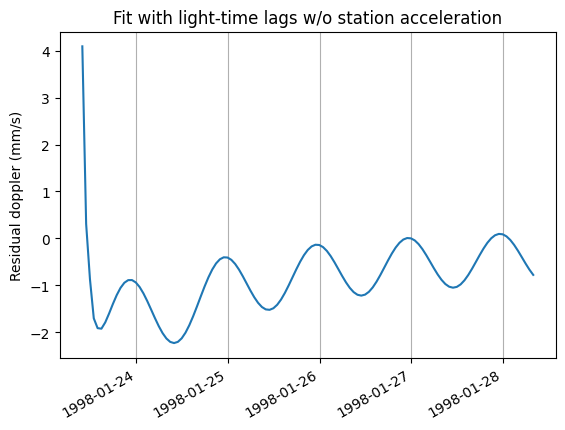

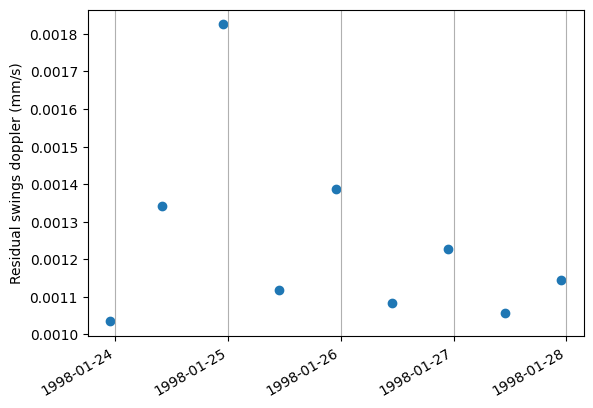

In [6]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit with light-time lags w/o station acceleration")

[0.003339034091267401, 0.0031907105908936806, 0.003270942834205995, 0.003189081067426408]


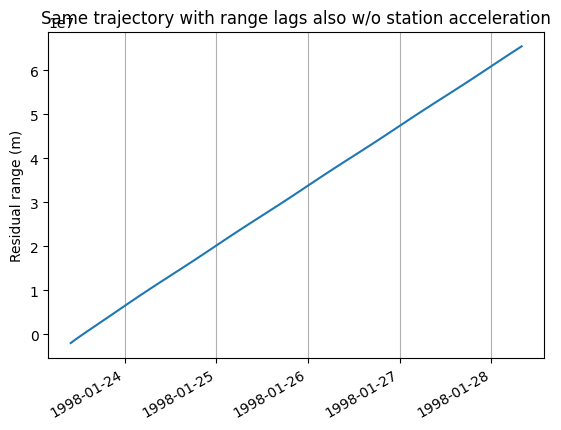

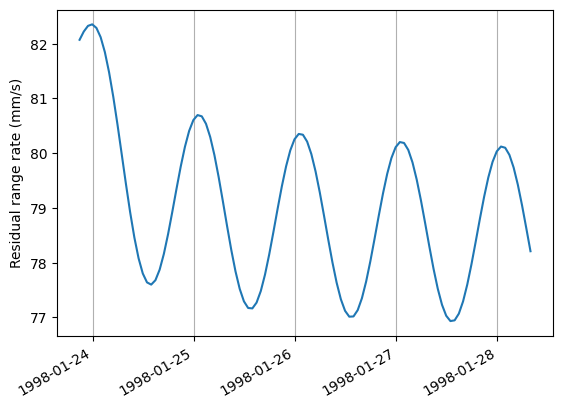

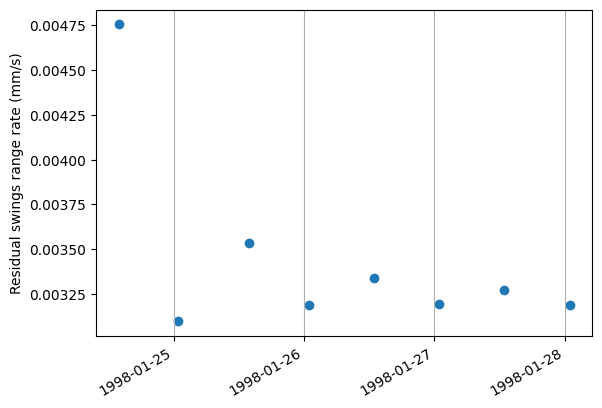

In [7]:
_ = ltresr_rates = reusefitr(ltfitv, epochs[:-1], rdata_ltlags, "Same trajectory with range lags also w/o station acceleration")

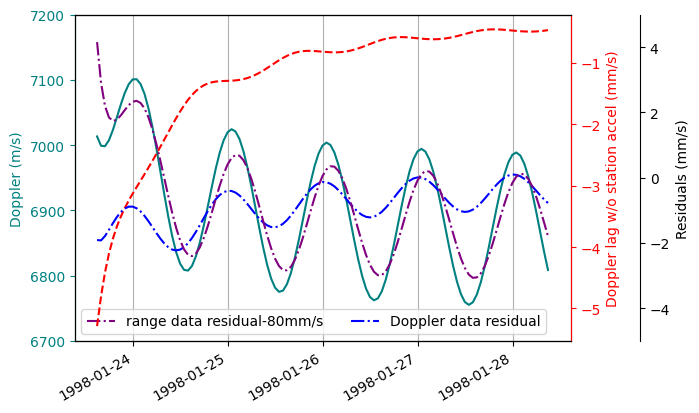

In [8]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")
    ax.set_ylim([6700, 7200])

    ax2 = ax.twinx()
    ax2.set_ylabel('Velocity lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residuals (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    ax3.set_ylim([-5, 5])

    p1, = ax.plot(epochs[5:], [v[0].to_value(u.m/u.s) for v in vdata_ref[4:]], 
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[5:], [v.to_value(u.mm/u.s) for v in vlags[4:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[5:], [1e3*v for v in ltfitv.result.residual[4:]],
                   linestyle='-.', color="blue", label="Doppler data residual")
    p4, = ax3.plot(epochs[5:], [1e3*v-80 for v in ltresr_rates[3:]],
                   linestyle='-.', color="purple", label="range data residual-80mm/s")

    ax.legend(handles=[p4, p3], loc="lower left", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')